# CLASSIFY DIGITS
let's try a simple sklearn deep network

In [4]:
from Classify_Symbols.classify_lib import *

In [5]:
import tarfile
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

#for data augmentation
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import SimilarityTransform

data_base_path = os.path.join(os.pardir, '..\\data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [6]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [7]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

### Remove the 9 labels

In [92]:
nb_data_train, nb_data_test =np.sum(~(train_labels == 9)),  np.sum(~(test_labels==9))
nb_data_train, nb_data_test

(54051, 8991)

In [93]:
train_images[0:nb_data_train,:,:] = train_images[~(train_labels == 9)]
test_images[0:nb_data_test,:,:] = test_images[~(test_labels == 9)]
train_labels[0:nb_data_train] = train_labels[~(train_labels == 9)]
test_labels[0:nb_data_test] = test_labels[~(test_labels == 9)]

In [94]:
np.sum(train_labels[0:nb_data_train]==9) , np.sum(test_labels[0:nb_data_test]==9) #to check there is NO 9 digits

(0, 0)

### DATA AUGMENTATION

In [95]:
# for train data
angles = np.random.randint(low = 0, high = 360, size = nb_data_train)       #integers are enough, 1 degree is very small
trans = np.random.uniform(low = -1, high = 1, size = (nb_data_train,2) )    #float as translation like 1.5 are also useful ! 
# for test data
angles_test = np.random.randint(low = 0, high = 360, size = nb_data_test)   #integers are enough, 1 degree is very small
trans_test = np.random.uniform(low = -1, high = 1, size = (nb_data_test,2) )#float as translation like 1.5 are also useful ! 

In [96]:
for i in np.arange(nb_data_train):
    T = SimilarityTransform( translation = trans[i] )
    train_images[i,:,:] = rotate(train_images[i,:,:], angles[i])
    train_images[i,:,:] = warp( train_images[i,:,:], inverse_map = T.inverse) 

for i in np.arange(nb_data_test):
    T = SimilarityTransform( translation = trans_test[i] )
    test_images[i,:,:] = rotate(test_images[i,:,:], angles_test[i])
    test_images[i,:,:] = warp( test_images[i,:,:], inverse_map = T.inverse) 

In [97]:
print(train_images.shape, test_images.shape)
print(train_labels.shape, test_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


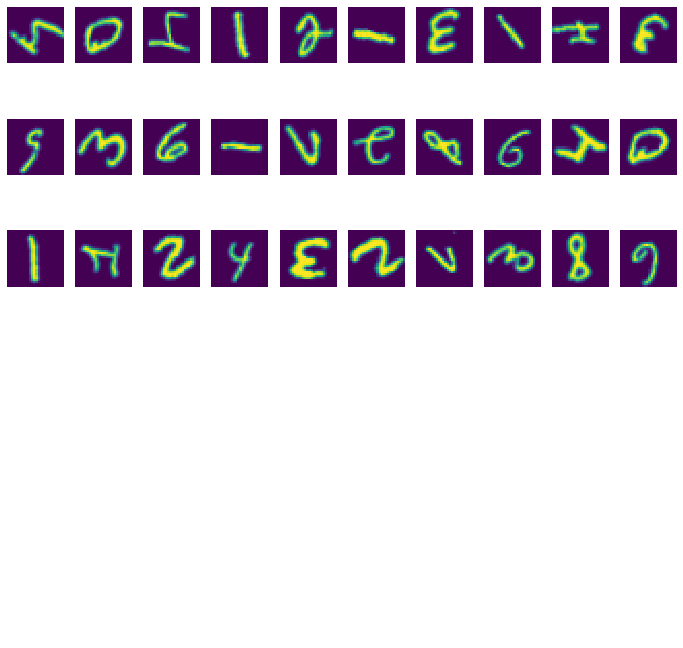

In [98]:
plot_pic( [train_images[i,:,:] for i in np.arange(0,30)])

### loading pictures as Kilian feeds them to me

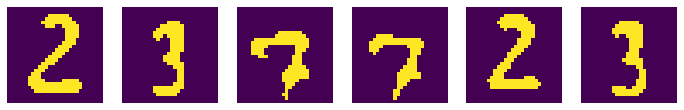

In [8]:
# Can be loaded using pickle and the following lines
with open('extractedImg.data', 'rb') as dataFile:
	listObj = pickle.load(dataFile)
    
digits_ls = [listObj[i]['img'] for i in [0,1,4,5,7,8] ]#just keep the digits (and discard the symbols)
digits = np.zeros( (len(digits_ls), 28,28))
for i in np.arange(len(digits_ls)):
    digits[i,:,:] = digits_ls[i]

plot_pic( digits_ls )

# A first network

In [101]:
# Training 

clf = MLPClassifier(solver='adam', activation='relu', alpha=0.3,
                    hidden_layer_sizes=(70, 30), random_state=1, verbose=True)

scaler = StandardScaler()

scaler.fit(vectImageArray(train_images[:nb_data_train,:]))
print("Done scaling")
X_train = scaler.transform(vectImageArray(train_images[:nb_data_train,:]))

clf.fit(X_train, train_labels[:nb_data_train])
print("Done training")

Done scaling
Iteration 1, loss = 1.31955019
Iteration 2, loss = 0.84780911
Iteration 3, loss = 0.70698050
Iteration 4, loss = 0.63848718
Iteration 5, loss = 0.59088264
Iteration 6, loss = 0.56119638
Iteration 7, loss = 0.53406746
Iteration 8, loss = 0.51736308
Iteration 9, loss = 0.50334499
Iteration 10, loss = 0.48783808
Iteration 11, loss = 0.47631782
Iteration 12, loss = 0.46646222
Iteration 13, loss = 0.45958674
Iteration 14, loss = 0.45746742
Iteration 15, loss = 0.44689323
Iteration 16, loss = 0.44091181
Iteration 17, loss = 0.43454496
Iteration 18, loss = 0.43023247
Iteration 19, loss = 0.42697138
Iteration 20, loss = 0.42066059
Iteration 21, loss = 0.41777533
Iteration 22, loss = 0.41548545
Iteration 23, loss = 0.41003497
Iteration 24, loss = 0.41271711
Iteration 25, loss = 0.40412071
Iteration 26, loss = 0.40210521
Iteration 27, loss = 0.39795203
Iteration 28, loss = 0.39959108
Iteration 29, loss = 0.39550555
Iteration 30, loss = 0.38737965
Iteration 31, loss = 0.38879077
Iter

In [102]:
# Testing 

X_test = scaler.transform(vectImageArray(test_images[:setSize,:]))

s = clf.score(X_test,test_labels[:setSize])
print("Resulting accuracy is : {}".format(s))

Resulting accuracy is : 0.8801


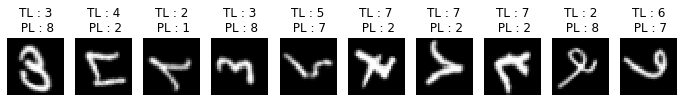

In [103]:
# Plotting some misclassified digits

nbrFalse = 0
maxFalse = 10

listFalseId = []
listFalsePred = []
for i in np.arange(test_labels.shape[0]-1) :
    if nbrFalse >= maxFalse:
        break
    
    pred = clf.predict(X_test[i:i+1,:])[0]
    if test_labels[i] != pred :
        listFalseId.append(i)
        listFalsePred.append(pred)
        nbrFalse = nbrFalse + 1
        
fig, axes = plt.subplots(1, maxFalse, figsize=(12, 3))
for ax, i, pred in zip(axes, listFalseId, listFalsePred):
    ax.imshow(test_images[i,:,:], cmap='gray')
    ax.axis('off')
    ax.set_title("TL : {}\n PL : {}".format(test_labels[i],pred))

# Now test how it goes with the picture from the videos

In [10]:
X_test_moodle = scaler.transform(vectImageArray(digits*255)) # x255 because the input pictures are uint8 ! 

NameError: name 'scaler' is not defined

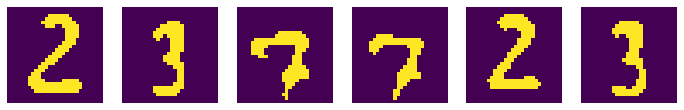

In [106]:
plot_pic( digits_ls)

In [109]:
clf.predict(X_test_moodle)

array([3, 3, 7, 7, 2, 3], dtype=int64)

In [110]:
X_test.shape

(6, 784)